---
title: Week 5 Tutorial 1, Orchestra Simulation
subtitle: Orchestra Scenario, Fluorite & Gypsum simulation
author:
  - name: Timo Heimovaara
    affiliations: Delft University of Technology, department of Geoscience & Engineering
    orcid: 
    email: t.j.heimovaara@tudelft.nl
license: CC-BY-NC-ND-4.0 (https://creativecommons.org/licenses/by-nc-nd/4.0/).
date: 2026-01-07
kernelspec:
    name: python3
    display_name: 'Python 3.13'
---

## Orchestra as a tool
This example illustrates how to use Python and ORCHESTRA to simulate the Ca - F - Gypsum example from Appelo and Postma chapter 4.
The next python cells imports the necessary libararies and checks the path to the input files required for the Orchestra simulation. Please note that this is only required for the jupyter-book version. For a stand-alone version of this notebook you need to start jupyter-lab from the directory with the input files.

In [29]:
# Import libraries required for running all simulations
import os
import sys
from IPython.utils import capture
from IPython.display import display, Markdown
from pathlib import Path
from contextlib import chdir

import numpy as np
import matplotlib.pyplot as plt
import PyORCHESTRA # here, the ORCHESTRA submodule is imported
import pandas as pd
import seaborn as sns

%matplotlib widget
sns.set()

# Prepare a file to capture PyOrchestra output
capture_file = open("pyorchestra_output.log", "w")


# pyOrchestra is implemented in C++
# Save original stdout file descriptor
original_stdout_fd = sys.stdout.fileno()

# Duplicate original stdout so we can restore it later
saved_stdout_fd = os.dup(original_stdout_fd)



# We need to import some Orchestra files. We need to know the path layout on 
# the local machine:
def find_book_root(start: Path | None = None) -> Path:
    """
    Walk upward from `start` (or CWD) until a directory containing Jupyter Book
    marker files is found. Returns the path to the book root.
    Raises FileNotFoundError if no root is found.
    """
    config_any = {"_config.yml", "_config.yaml"}      # some projectrs use .yaml
    myst_any = {"myst.yml", "myst.yaml"}            # jupyter-book uses _toc.yml

    cur = Path(Path.cwd()).resolve()

    for parent in [cur, *cur.parents]:
        children = {f.name for f in parent.iterdir()} if parent.exists() else set()
        has_any_config = bool(config_any & children)
        has_any_myst = bool(myst_any & children)
        if has_any_config and has_any_myst:
            return parent

    raise FileNotFoundError(
        f"Could not find Jupyter Book root (no _config.y* and myst.y* found above {cur})"
    )


def path_from_book_root(*parts: str | Path) -> Path:
    root = find_book_root()
    p = (root.joinpath(*parts)).resolve()
    if not p.exists():
        raise FileNotFoundError(f"Path not found: {p}")
    return p

# In order for orchestra to run we need to change directory to the directory with the input file:


# Example usage:
# input_file = path_from_book_root("content", "week 02", "Orchestra_simulation", "chemistry1.inp")
# print("Input file:", input_file)

orchestra_path = path_from_book_root("content", "week 05", "Tutorial-1-Orchestra-Ca-F-Gypsum")
# print(orchestra_path)

## Download this script and the required ORCHESTRA files
TODO Create an yml for a local python environment
TODO Create zip file with the correct files. Explain how to install Orchestra using pip in a local python environment.
TODO Update all files so that they are well documented and describe the system

pyorchestra will be initialize with the correct chemistry file...

explain that InVars are the species used to define the totals. 
explain that OutVars is the list of Orchestra variables that are exported to python for post-processing or necessary for simulation.

Once prinicple problem is known we can create and initialize a pyorchestra object.

## Define chemical system: Fluorite, Gypsum, water using the ORCHESTRA-GUI
In order to solve a chemical equilibrium problem with pyOrchestra, we need to define our chemical system first. Orchestra defines this system with a number of text files. The most important one is the so-called chemistry input file (*chemistry1.inp*). This file is most easily made using the Orchestra GUI which can be accessed by clicking on the orchestrat2023.jar file.

The most convenient approach is to start with a skeleton problem (a working ORCHESTRA simulation) and then adjust the files step by step. 

:::{figure} images/Primary_entities_Master_species.png
:name: master_species
:align: center
:width: 90%
Orchestra interface for definition of Master Species
:::

Using the Orchestra GUI shown in [](#master_species)  we are able to define a system of the primary entities. You do this by selecting the **Chemistry** tab on the right in the ORCHESTRA-COMPOSER window. The **Chemistry** tab shows a number of tabs which fill the *chemistry1.inp* file. We start by selecting tab **Primary entities/ Master Species**. Remember that we select the Master Species in such a way that we can create all other species for our problem. In addition we need to use these species to define the total moles of each master species present in the system (including the amounts of these master species present in the secondary species).

In this example we start with a solution of $\text{Ca}^{+2}$ and $\text{F}^-$ with unknown other ions present. We assume that the other ions are controlled by the water equilibrium which we always need when working on aqueous systems. We set the pH to control the charge balance (i.e. charge will be balanced by adding $\text{H}^+$ or $\text{OH}^-$ when necessary.
According to the example, Gypsum is added to lower the $\text{F}^-$ by precipitation with $\text{Ca}^{+2}$ as Fluorite. We literally do this by adding SO4-2.tot as a master species. Please note the concentration of $\text{SO}_4^{-2}$ is controlled by Gypsum. 

The initial amounts of of ${Ca}^{+2}$ and $\text{F}^-$ are defined as Ca+2.tot and F-.tot and correspond to the total amounts present in solution. In order to have this solution in equilibrium with and excess amount of Gypsum we add it as Gypsum[s].tot

In filling in the table you should have something similar to: 

|Primary entity|Input Variable|Fix log activity|Log activity|Concentration|Phase|Expression|
|--|--|--|--|--|--|--|
|Ca+2||||1e-9|tot||
|F-||||1e-9|tot||
|H|pH|x|7.0|||H.logact=-pH|
|H2O||x|-0.0||||
|SO4-2||||1e-9|tot||

Orchestra will use these primary entities, and their initial values to calculate the total elemental composition in the complete system. The fixed log-activties indicate that the total can vary during the simulation, as long as the log-activity condition is maintained. 

### Phases & Reactions
On the **Phases & Reactions** tab shown in figure [](#phases_reactions) we define the reaction network of our system. The schematic on the left-hand side is used to define how the different phases (gas, liquid and solids) are connected, which we will ignore for now.

:::{figure} images/Phases_Reactions.png
:name: phases_reactions
:align: center
:width: 90%
Orchestra interface for definition of Master Species
:::

The table on this tab shows all possible reactions in this system. You should recognize that this table originates from the log-transformed mass action law. The table shows the logK-value, in which phase the species can be found, followed by the stoichiometry of the reaction as a function of the master-species or convenient secondary species in the system. Please note the reaction for SO4-2 showing how it is formed from Gypsum and $\text{Ca}^{+2}$.

We can select which species we want to include for our system using the Include buttons. For now we include all because we want to assess if minerals are present using the Saturation Index (SI).

### Other tabs
On the **Activity correction** tab we select the model equation used by ORCHESTRA to calculate the activities of the species in solution. We will use the Davies model and mark the field **Calculate Ionic Strenghth** which you can check for your self. 
On the **Settings** tab we mark the field **Include SI minerals**.

The other tabs we leave as is, but you should take a look at these tabs anyway. On the **Variables** tab the user can set all kinds of constants for the calculations. However, many of these will be "overruled" by us in the Python simulations. The **Adsorption models** tab is used to calculate adsortion of ionic compounds to all kinds of surfaces, lies beyond the scope of this course. The **Predominance Diagram** tab will be used in a later lecture when we discuss redox reactions. Finally the **Output selector** tab is useful to find out what variables are present in our current ORCHESTRA simulation.

### Using Orchestra to run the scenario
It is possible to use the ORCHESTRA GUI to run the simulation, and this has been prepared using the **Input** and **Output** tabs on the right of the window. Please have look at these tabs and they should be rather "self explanatory". 



## Running the Ca-F-Gypsum scenario in a Python notebook
We will use a Python notebook and Orchestra to calculate the trajectory from A via point B to Point C in the example from Appelo & Postma chapter 4.1. We start from the initial situation without any Gypsum and know $\text{Ca}^{+2}$ and $\text{F}^-$ concentrations. Then we add small consecutative amounts of Gypsum until we have a final equilirbium between Gypsum, Fluorite and the solution.

In order to run the Ca-F-Gypsum scenario is a notebook we have to follow a systematic approach which consists of the following standard steps:
1. define the domain for our problem
2. define the primary species which change during our scenario
3. initialize the problem
4. run the problem
5. process the output

### 1. Define the domain
In the example as given by Appelo and Postma, no information is given about the volume of water involved. Concentrations are given in mg/liter. In this case it is a good approach to do the simulation for 1 liter of water (or better for 1 kg of water). 
```{note} Why is 1 kg water a better choice than 1 liter of water?
In your answer, please take the density of the solution in to consideration, and especially how the density may change due changes in the concentrations of solutes.
```
For our simulation we do not require any information about the gas volume or solid volumes.

### 2. Define the primary species
The primary species are as defined above with the ORCHESTRA GUI. Please note that the values required by ORCHESTRA have to be in moles. In order to get moles/liter the volume of water has to be set to 1 liter, and the density of water need to be given as well.

### 3. Initialise the problem 
The initial condition for our problem is the situation without any Gypsum present.
Once pyOrchestra is initialized, running a simulation consists of a series of steps where the values of the required set of input variables are passed via *InVARS* to ORCHESTRA, after which a set of corresponding output variables are passed back in *OutVars*.

ORCHESTRA is initialized in pyOrchestra using the inputfile *chemistry1.inp*, created above with the ORCHESTRA-GUI. After initialization in Python, we know which variables will be passed through *OutVars* and can be used in *InVars*.

The following code shows how to do this.


In [30]:
#--- Initialize problem --- 
# for initialization we need to temporarily move to the directory containing the 'chemistry1.inp' file.
with chdir(orchestra_path):

    # Input file is generated with Orchestra GUI
    InputFile = 'chemistry1.inp'
    NoCells = 1 #only 1 cell to have a 0-D system with 1liter of water
    
    # We define the input variables that will be changed in the script
    InVars = np.array(['Ca+2.tot', 'F-.tot', 
                       'SO4-2.tot',
                       'Gypsum[s].tot',
                       'watervolume'
                       ])
    
    # We select the output from Orchestra we need to use
    OutVars = np.array(['pH', 'H+.con', 'H+.tot', 
                        'SO4-2.tot', 'SO4-2.con', 'SO4-2.logact','SO4-2.diss',
                        'HSO4-.tot', 'HSO4-.con', 'HSO4-.logact',
                        'Ca+2.tot', 'Ca+2.con', 'Ca+2.logact', 'Ca+2.diss', 
                        'CaF+.con', 'CaOH+.con', 'CaSO4.con',
                        'F-.tot', 'F-.con', 'F-.logact', 'F-.diss',
                        'Gypsum[s].si', 'Gypsum[s].tot', 'Gypsum[s].un','Gypsum[s].logact',
                        'Fluorite[s].si', 'Fluorite[s].tot', 'Fluorite[s].un', 'Fluorite[s].logact',
                        'I', 'chargebalance', 'watervolume' ])

    # Associate a variable with the pyOrchestra.ORCHESTRA() class
    p = PyORCHESTRA.ORCHESTRA()

    # Initialize the class with the parameters defined above
    p.initialise(InputFile, NoCells, InVars, OutVars)


Reading and expanding calculator new stylechemistry1.inp
Scanning file: chemistry1.inp
Scanning file: objects2025.txt
Scanning file: chemistry1.inp
Scanning file: objects2025.txt
Including file: chemistry1.inp
Scanning file: objects2025.txt
0.037 sec.
	Reading variables .... 0.015 s
testing:
8:Ca+2.tot
10:F-.tot
13:SO4-2.tot
16:Gypsum[s].tot
17:watervolume
11:pH
18:H+.con
19:H+.tot
13:SO4-2.tot
20:SO4-2.con
12:SO4-2.logact
21:SO4-2.diss
22:HSO4-.tot
23:HSO4-.con
24:HSO4-.logact
8:Ca+2.tot
25:Ca+2.con
7:Ca+2.logact
26:Ca+2.diss
27:CaF+.con
28:CaOH+.con
29:CaSO4.con
10:F-.tot
30:F-.con
9:F-.logact
31:F-.diss
32:Gypsum[s].si
16:Gypsum[s].tot
15:Gypsum[s].un
33:Gypsum[s].logact
34:Fluorite[s].si
35:Fluorite[s].tot
14:Fluorite[s].un
36:Fluorite[s].logact
3:I
6:chargebalance
17:watervolume
Initialise Completed! the following IO parameters will be used:
0 : Node_ID : 0
1 : minTol : 0.001
2 : H2O.logact : 0
3 : I : 0.1
4 : T : 298.15
5 : logI : -2
6 : chargebalance : 0
7 : Ca+2.logact : -9
8 :

Please note that the output of this code is what ORCHESTRA echos back. ORCHESTRA uses a set of variables in order to store the input variables and the results of the calculations, in this case 33. The top part of the output shows the output requested by us through *OutVars* together with the values used during initialization.

### Run the Problem
The aim of the scenario for now is to see if we can replicate a similar graph as figure 4.1 of Appelo and Postma.

:::{figure} images/Appelo&Postma_fig4.1.png
:name: appelo_fig4_1
:align: center
:width: 50%
Appelo & Postma figure 4.1
:::

To do this we carry out the following steps.
- step 1: Initial condition. We start at point A
- step 2: Final condition, point C system in equilibrium with a large amount of Gypsum
- step 3: Addition of small amounts of Gypsum to move towards point B and then once saturation of Fluorite is achieved towards point C.
- step 4: Process output

### Step 1: Calculate equilibrium at Point A

In [31]:
# %%
# Step 1, initial condition.
# InVars need to contain floats
IN = np.array([np.ones_like(InVars)]).astype(float)

Ca_ini = 2.495e-4  # moles
F_ini = 2.895e-4   # moles

IN[0][np.where(InVars == 'Ca+2.tot')] = Ca_ini # moles
IN[0][np.where(InVars == 'F-.tot')] = F_ini # moles
IN[0][np.where(InVars == 'SO4-2.tot')] = 1e-20 # No Gypsum (initial conditions)
IN[0][np.where(InVars == 'Gypsum[s].tot')] = 1e-20 # No Gypsum (initial conditions)
IN[0][np.where(InVars == 'watervolume')] = 1.0 # No Gypsum (initial conditions)

# Calculate equilibrium conditions for initial situation (Point A in chapter 4.1)
OUT = p.set_and_calculate(IN)
Res_PointA = pd.DataFrame(OUT,columns=OutVars)
print("Point A: Initial condition without Gypsum")
print(Res_PointA[['Ca+2.con', 'F-.con', 'SO4-2.con', 'Gypsum[s].si', 'Fluorite[s].si']])


Try a first calculation with iia switched off....
Parsing expressions of chemistry1.inp..... 
Point A: Initial condition without Gypsum
   Ca+2.con    F-.con     SO4-2.con  Gypsum[s].si  Fluorite[s].si
0  0.000248  0.000289  3.904030e-17    -15.511753       -0.265139
Optimizing expressions of chemistry1.inp..... 0.075 sec.
1401 variables, 3636 expressions, 5 equations.
First calculation was successful!
Repeat calculation with iia switched on..
Switching on: logI: -2
Switching on: pH: 7
This was successful!!


### Step 2: Define final conditions (Point C)
Aqueous solution with $\text{Ca}^{+2}$ and $\text{F}^-$, in equilibrium with Gypsum.

In [32]:
# %%
# Step 2, Initial condition in equilibrium with an excess of Gypsum
# IN has already been initialized above, we only need to change the Gypsum[s].tot variable

IN[0][np.where(InVars == 'Ca+2.tot')] = 1 + Ca_ini # moles
IN[0][np.where(InVars == 'F-.tot')] = F_ini # moles
IN[0][np.where(InVars == 'SO4-2.tot')] = 1 # really large amount of Gypsum for 1 liter!

# %%

OUT = p.set_and_calculate(IN)
Res_PointC = pd.DataFrame(OUT,columns=OutVars)
print(IN[0])
print("Point C: Initial condition without Gypsum")
print(Res_PointC[['Ca+2.con', 'F-.con', 'SO4-2.con', 'SO4-2.diss','Gypsum[s].si', 'Fluorite[s].si','Gypsum[s].tot','Fluorite[s].tot']])

[1.0002495e+00 2.8950000e-04 1.0000000e+00 1.0000000e-20 1.0000000e+00]
Point C: Initial condition without Gypsum
   Ca+2.con    F-.con  SO4-2.con  SO4-2.diss  Gypsum[s].si  Fluorite[s].si  \
0  0.010419  0.000096   0.010288    0.015911           0.0             0.0   

   Gypsum[s].tot  Fluorite[s].tot  
0       0.984089         0.000094  


### Step 3: add small amounts of Gypsum and save the intermediate results
The idea is to add small increments of gypsum to our solution. The figure in Appelo shows the x-axis ranging from roughly 1 to 1000 ppm of $\text{Ca}^{+2}$. We need to calculate the corresponding molar amounts of Ca+2. Parts per million corresponds to mg/kg (or mg/liter). With the molar mass of Calcium (40.1 g/mol) we can calculate the range required for adding Gypsum

In [65]:
# we add Gypsum in 100 increments between 0 ppm and 1000 ppm

mmCa = 40.1  # g/mol
mmF = 19.0 # g/mol
# Gypsum_range = np.logspace(-4, 1, 125)
Gypsum_range = np.linspace(2.1e-4, 3.4e-4, 52)
#  Prepare an array to store all results from our scenario
all_Res = np.zeros([len(Gypsum_range),len(OutVars)])

# loop over Ca_Range 
# we use a counter ii in order to store the results
ii = -1
for gypsum in Gypsum_range:
    # change Gypsum in InVars
    IN[0][np.where(InVars == 'Ca+2.tot')] = gypsum + Ca_ini
    IN[0][np.where(InVars == 'SO4-2.tot')] = gypsum

    # run ORCHESTRA
    OUT = p.set_and_calculate(IN)
    ii = ii + 1
    all_Res[ii] = OUT[0]

    # Create a dataframe from all_Res
Res_Simulation = pd.DataFrame(all_Res,columns=OutVars)

## Process Output
To process the output we first generate a similar figure as from Appelo and Postma. In order to be able to do this, we change the concentrations from mol/liter to mg/liter (or ppm). Please note that we use Ca+2.diss and F-.diss because this contains the sum of all Ca+2 and F- species in solution. 
We plot the results on a log log graph.


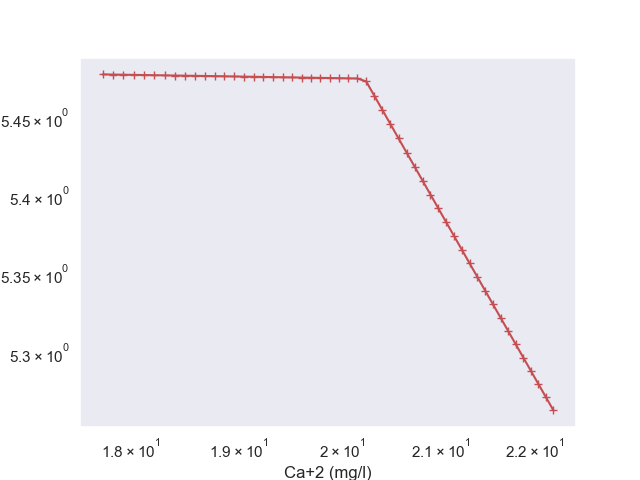

In [66]:
# Process output
# create a plot of F- against Ca+2 on a log log scale where the concentrations are in mg/liter
Res_Simulation['Ca+2.mgl'] = Res_Simulation['Ca+2.con'] * mmCa * 1000
Res_Simulation['F-.mgl'] = Res_Simulation['F-.con'] * mmF * 1000

# we can easily make the plot 
fig1,ax1 = plt.subplots()
ax1.plot(Res_Simulation['Ca+2.mgl'],Res_Simulation['F-.mgl'], 'r+-' )
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Ca+2 (mg/l)')
ax1.set_ylabel('F- (mg/l)')
ax1.grid(True)

If we compare our figure with figure 4.1 from Appelo and Postma we see that it is very similar. In the text of chapter 4, Appelo and Postma state that at point C, the system is in equilibrium with both Gypsum and Fluorite, this would imply that the concentrations of Ca+2, F- and SO4-2 no longer change as we add more Gypsum. We can check this by plotting the concentrations against the amount of Gypsum added.



Text(0, 0.5, 'Concentration (moles/liter)')

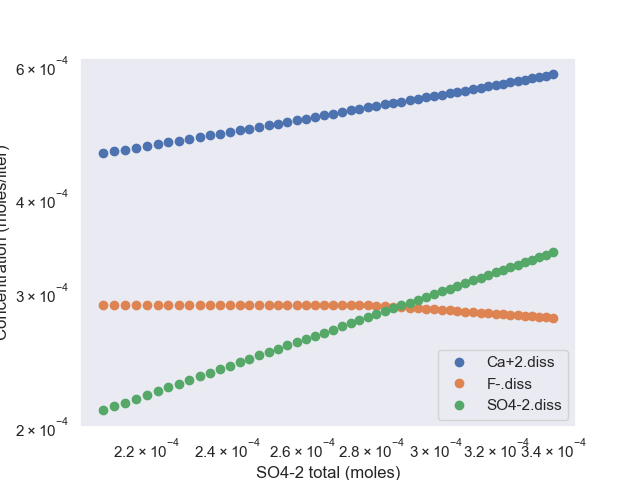

In [69]:
fig2,ax2 = plt.subplots()
species_list = ['Ca+2.diss','F-.diss', 'SO4-2.diss']
for species in species_list:
    ax2.plot(Res_Simulation['SO4-2.tot'], Res_Simulation[species], 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True)
ax2.legend(species_list)
ax2.set_xlabel('SO4-2 total (moles)')
ax2.set_ylabel('Concentration (moles/liter)')

```{exercise} Explain
Explain this graph in your own words. 
```

### Report quantitative changes from Point A to Point C
With a model like this we can report the quantitative differences in the solution composition between Point A and Point B.


In [70]:
# Process results
deltaCa = (Res_PointC['Ca+2.con'] - Res_PointA['Ca+2.con']).values[0]
deltaF = (Res_PointC['F-.con'] - Res_PointA['F-.con']).values[0]
deltaSO4 = (Res_PointC['SO4-2.con'] - Res_PointA['SO4-2.con']).values[0]

out_df = pd.concat([Res_PointA[['Ca+2.con','F-.con','SO4-2.con', 'Ca+2.logact','F-.logact','SO4-2.logact']],
                    Res_PointC[['Ca+2.con','F-.con','SO4-2.con', 'Ca+2.logact','F-.logact','SO4-2.logact']]])
out_df.index = ['initial','final']
out_df.loc['delta',['Ca+2.con', 'F-.con', 'SO4-2.con']] = out_df.loc['final',['Ca+2.con', 'F-.con', 'SO4-2.con']] - out_df.loc['initial',['Ca+2.con', 'F-.con', 'SO4-2.con']]


## Results
The change in calcium concentration due to dissolution of Gypsum is: {eval}`format(deltaCa,".3f")` mol/l.
The change in sulphate concentration due to dissolution of Gypsum is: {eval}`format(deltaSO4,".3f")` mol/l.
The change in fluoride concentration due to dissolution of Gypsum is: {eval}`format(deltaF*1000,".3f")` mmol/l.

The quantitative results of this exercise are:



In [71]:
from IPython.display import HTML, display_markdown

out_df_html = out_df.to_html(index=False)  # or use a template
display(HTML(out_df_html))

# out_df_md = out_df.to_markdown(index=False)
# display_markdown(out_df_md, raw=True)

Ca+2.con,F-.con,SO4-2.con,Ca+2.logact,F-.logact,SO4-2.logact
0.000248,0.000289,3.904030e-17,-3.659495,-3.552828,-16.462246
0.010419,0.000096,1.028755e-02,-2.302242,-4.098885,-2.307745
0.010171,-0.000193,1.028755e-02,NaN,NaN,NaN


In [72]:
sel_neg = Res_Simulation['Fluorite[s].si']<0
print(np.where(sel_neg)[0][-10:])


[23 24 25 26 29 33 34 42 48 49]


In [74]:
# print(Res_Simulation.loc[np.where(sel_neg)[0][-10:],['Fluorite[s].si','Ca+2.diss', 'F-.diss', 'Gypsum[s].si','SO4-2.diss']])
print(Res_Simulation.loc[range(20,50),['Fluorite[s].si','Ca+2.diss', 'F-.diss', 'Gypsum[s].si','SO4-2.diss']])

    Fluorite[s].si  Ca+2.diss   F-.diss  Gypsum[s].si  SO4-2.diss
20   -1.144910e-02   0.000510  0.000289     -2.476720    0.000261
21   -9.741332e-03   0.000513  0.000289     -2.470993    0.000264
22   -8.042893e-03   0.000516  0.000289     -2.465315    0.000266
23   -6.353693e-03   0.000518  0.000289     -2.459687    0.000269
24   -4.673636e-03   0.000521  0.000289     -2.454105    0.000271
25   -3.002670e-03   0.000523  0.000289     -2.448571    0.000274
26   -1.340624e-03   0.000526  0.000289     -2.443082    0.000276
27    1.394520e-10   0.000528  0.000289     -2.437669    0.000279
28    0.000000e+00   0.000531  0.000289     -2.432428    0.000281
29   -8.881784e-16   0.000533  0.000288     -2.427228    0.000284
30    8.881784e-16   0.000535  0.000288     -2.422068    0.000286
31    0.000000e+00   0.000538  0.000287     -2.416949    0.000289
32    0.000000e+00   0.000540  0.000287     -2.411869    0.000292
33   -8.881784e-16   0.000542  0.000287     -2.406827    0.000294
34   -8.88

From this list we can find point B, the first point where Fluorite[s].si == 0: Ca+2.diss = 5.28e-4, F-.diss = 2.895, SO4-2.diss = 2.79e-4.
We could create a solver to iteratively solve for Fluorite[s].si == 0